<a href="https://www.kaggle.com/code/eighteyes/titanic-data-analysis-and-ml-first-pass?scriptVersionId=121274275" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Start
Hi Kaggle, this is my first notebook with some rudimentary ML classification after making my way through a few courses on Kaggle learn. I'm have an extensive background in software development with a little data analysis. The stories behind data are very interesting, especially the outliers. For instance, I found one category of passenger, I'm calling `comped` because they paid low fares, got good cabins, and all perished. Typically, high class tickets would have indicated a higher then ordinary chance of survival. It's very likely this is a quirk of the small sample size, but interesting to uncover. 

# Data Notes

In [1]:
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
# Variable Notes
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower
# age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
# sibsp: The dataset defines family relations in this way...
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)
# parch: The dataset defines family relations in this way...
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nltk
import seaborn as sns


# Data Import

In [3]:
# What are we working with?
X = pd.read_csv('/kaggle/input/titanic/train.csv')

print(X.dtypes)
X.head()


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing
Exploring the dataset we want to cast categories into numerical values and fix all the cabin NaNs. Then we can start looking for correlations.  

In [4]:
# Reusable preprocessing, for test time
def preprocess(df):
  ## Lowercase indices
  df.columns = df.columns.astype(str).str.lower()

  df['gender'] = df['sex'].map({'male':0, 'female':1})

  # bigger names = more important = survived?
  df['namelength'] = df.name.apply(lambda s: len(s))

  # get rid of string data in ticket numbers
  df['ticket'] = df.ticket.astype(str).str.rsplit(n=1)

  # remove decimals
  df['age'].fillna(df.age.mean(), inplace=True)
  df['fare'].fillna(df.fare.mean(), inplace=True)
  df['age'] = df.age.astype('int64')
  df['fare'] = df.fare.astype('int64')

  df.cabin.fillna('NONE', inplace=True)
  df['cabinType'] = df['cabin'].replace('/d+', '')
  # multiples are for families, select first for floor
  df['cabinType'] = df['cabinType'].str[0]

  # family size seems to negatively correlate with survival
  df['familySize'] = df['sibsp'] + df['parch']
  df.drop(['sibsp', 'parch'], axis=1, inplace=True)

  # categorize cabin floor 
  df.cabinType = pd.Categorical(df.cabinType)
  df['cabinCat'] = df.cabinType.cat.codes

  # categorize port
  df.embarked = pd.Categorical(df.embarked)
  df.embarked = df.embarked.cat.codes
  # 0 - C , 1 - q, 2 - s
  
  # bin age
  df['ageGroup'] = pd.cut(df.age, bins=5, labels=range(5))
    
  return df

X = preprocess(X)

X.head()

,passengerid,survived,pclass,name,sex,age,ticket,fare,cabin,embarked,gender,namelength,cabinType,familySize,cabinCat,ageGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22,"[A/5, 21171]",7,NONE,2,0,23,N,1,7,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,"[PC, 17599]",71,C85,0,1,51,C,1,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26,"[STON/O2., 3101282]",7,NONE,2,1,22,N,0,7,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,[113803],53,C123,2,1,44,C,1,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35,[373450],8,NONE,2,0,24,N,0,7,2


# Exploration
What can we uncover from the initial dataset.
- gender is the strongest influence on survival
- pclass seems more useful then fare or cabin
- age doesn't seem like a factor
- name length is curiously strong, maybe women have longer names

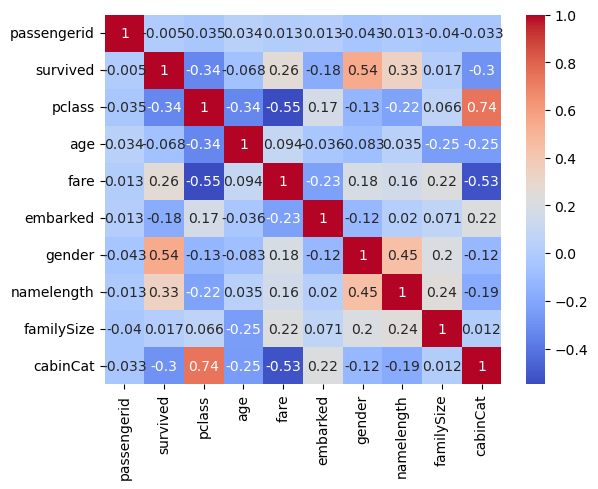

In [5]:
# what correlations can we find
sns.heatmap(X.corr(), cmap='coolwarm', annot=True)
plt.show()

# check survival distribution
Some of the correlations are clear, gender, fare, others require more investigation to see their impact. Interesting that the length of someone's name has an impact on their survival... 

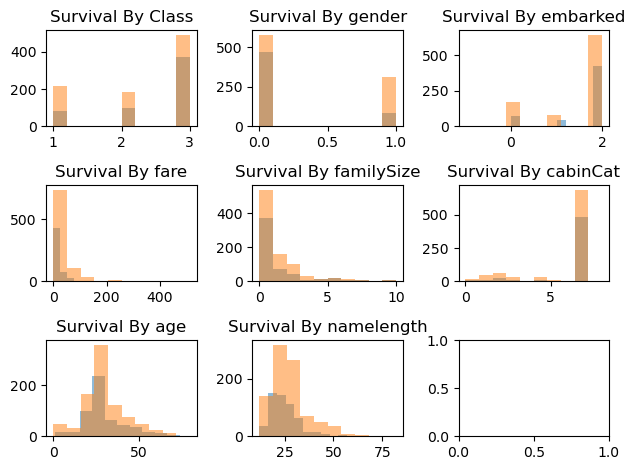

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3)

y = X['survived']
died = X[y == 0]

axs[0,0].hist(died['pclass'], alpha=0.5)
axs[0,0].hist(X['pclass'], alpha=0.5 )
axs[0,0].set_title('Survival By Class')

axs[0,1].hist(died['gender'], alpha=0.5)
axs[0,1].hist(X['gender'], alpha=0.5 )
axs[0,1].set_title('Survival By gender')

axs[0,2].hist(died['embarked'], alpha=0.5)
axs[0,2].hist(X['embarked'], alpha=0.5 )
axs[0,2].set_title('Survival By embarked')

axs[1,1].hist(died['familySize'], alpha=0.5) 
axs[1,1].hist(X['familySize'], alpha=0.5)
axs[1,1].set_title('Survival By familySize')

axs[1,2].hist(died['cabinCat'], alpha=0.5)
axs[1,2].hist(X['cabinCat'], alpha=0.5)
axs[1,2].set_title('Survival By cabinCat')

axs[1,0].hist(died['fare'], alpha=0.5)
axs[1,0].hist(X['fare'], alpha=0.5)
axs[1,0].set_title('Survival By fare')

axs[2,0].hist(died['age'], alpha=0.5)
axs[2,0].hist(X['age'], alpha=0.5)
axs[2,0].set_title('Survival By age')

axs[2,1].hist(died['namelength'], alpha=0.5)
axs[2,1].hist(X['namelength'], alpha=0.5)
axs[2,1].set_title('Survival By namelength')

plt.tight_layout()
plt.show()

# Groups to explore
Different segments and how survival rates were impacted. Obvious ones here, like `gender` and `fare`, less intuitive are that having a large family leaves you less well off then paying less for a ticket, or that deck B would be well suited. 

In [7]:

# interesting groups
nocabin = X[X['cabin'] == 'NONE']
rich = X[X['fare'] > 100]
first = X[X['pclass'] == 1]
poor = X[X['fare'] < 10]
# b is best
bfloor = X[X['cabinCat'] == 2]
family = X[X['familySize'] > 3]
men = X[X['gender']==0]
women = X[X['gender']==1]
adult = X[X['age']>18]
adultmen = X[(X['age'] > 13) & (X['gender']==0)]

tots = X[X['age']<=5]
kid = X[(X['age']<10) & (X['age']>5)]

youngboy = X[(X['age'] < 13) &(X['gender']==0)]

younggirl = X[(X['age'] < 13) &(X['gender']==1)]
senior = X[X['age'] > X.age.median() + 13.013778302447072 ]
french = X[X['embarked'] == 0 ]

# 100% survival rate
notlucky = X[(X.cabinType == 'B') & (X.familySize < 2) & (X.gender == 1)]

# good cabins for dirt cheap, all died
c = X[X['pclass'] <= 2]
c= c[c['fare'] < 10 ]
comped = c

X.head()


,passengerid,survived,pclass,name,sex,age,ticket,fare,cabin,embarked,gender,namelength,cabinType,familySize,cabinCat,ageGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22,"[A/5, 21171]",7,NONE,2,0,23,N,1,7,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,"[PC, 17599]",71,C85,0,1,51,C,1,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26,"[STON/O2., 3101282]",7,NONE,2,1,22,N,0,7,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,[113803],53,C123,2,1,44,C,1,2,2
4,5,0,3,"Allen, Mr. William Henry",male,35,[373450],8,NONE,2,0,24,N,0,7,2


# Group Survival Rates

In [8]:
def calcSurvival(g):
    return g[g.survived==1].size /  g.size

print('overall', calcSurvival(X))
print('nocabin', calcSurvival(nocabin))
print('rich', calcSurvival(rich))
print('firstclass', calcSurvival(first))
print('poor', calcSurvival(poor))
print('family', calcSurvival(family))
print('notlucky', calcSurvival(notlucky))
print('comped', calcSurvival(comped))
print('bfloor', calcSurvival(bfloor))

print('adultmen', calcSurvival(adultmen))
print('men', calcSurvival(men))

print('women', calcSurvival(women))

print('kid', calcSurvival(kid))
print('youngboy', calcSurvival(youngboy))

print('younggirl', calcSurvival(younggirl))
print('adult', calcSurvival(adult))

print('senior', calcSurvival(senior))
print('tots', calcSurvival(tots))
print('french', calcSurvival(french))

overall 0.3838383838383838
nocabin 0.29985443959243085
rich 0.7358490566037735
firstclass 0.6296296296296297
poor 0.19940476190476192
family 0.16129032258064516
notlucky 1.0
comped 0.0
bfloor 0.5932203389830508
adultmen 0.16296296296296298
men 0.18890814558058924
women 0.7420382165605095
kid 0.3888888888888889
youngboy 0.5675675675675675
younggirl 0.59375
adult 0.3617021276595745
senior 0.3643410852713178
tots 0.7045454545454546
french 0.5535714285714286


# Define Target
Lets get into the modeling and prediction. Not trying anything fancy right now, just a basic workflow.

In [9]:
y = X['survived']

# remove non numbers
X = X.select_dtypes(exclude=['object'])

# Drop Target from dataset
# X1 = X.drop('survived', axis=1, inplace=True)

# Model Validation

In [10]:
# Start
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ml setup
# features = ['age','ageGroup','gender','pclass','cabinCat','familySize','namelength','fare']

features = ['ageGroup','gender','cabinCat','familySize']
# note: don't replace X next time
# X1 = X[features]

In [11]:
X1 = X
X_train, X_test, y_train, y_test = train_test_split(X1,y,train_size=.8, random_state=42)

from sklearn.metrics import accuracy_score

features = ['age','ageGroup','gender','pclass','cabinCat','familySize','namelength','fare']

print(y_train, y_test)
# Iterate over the features and train logistic regression models
for feat in features:
    X_train_sub = X_train[[feat]]
    X_test_sub = X_test[[feat]]

    # Train a logistic regression model
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_sub, y_train)
    
    # Evaluate the model on the test set
    y_pred = clf.predict(X_test_sub)
    acc = accuracy_score(y_test, y_pred)
    
    # Print the results
    print('Features:', feat)
    print('Accuracy:', acc)

331    0
733    0
382    0
704    0
813    0
      ..
106    1
270    0
860    0
435    1
102    0
Name: survived, Length: 712, dtype: int64 709    1
439    0
840    0
720    1
39     1
      ..
433    0
773    0
25     1
84     1
10     1
Name: survived, Length: 179, dtype: int64
Features: age
Accuracy: 0.553072625698324
Features: ageGroup
Accuracy: 0.6145251396648045
Features: gender
Accuracy: 0.7821229050279329
Features: pclass
Accuracy: 0.7039106145251397
Features: cabinCat
Accuracy: 0.6927374301675978
Features: familySize
Accuracy: 0.6983240223463687
Features: namelength
Accuracy: 0.6256983240223464
Features: fare
Accuracy: 0.6703910614525139


In [12]:
# ml setup
# features = ['age','ageGroup','gender','pclass','cabinCat','familySize','namelength','fare']
# v6 features, scores .76
# features = ['ageGroup','gender','cabinCat','familySize']
features = ['gender','pclass', 'familySize', 'ageGroup']
# note: don't replace X next time
X1 = X[features]

X_train, X_test, y_train, y_test = train_test_split(X1,y,train_size=.8, random_state=42)

# Define the models to try
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
#     'Support Vector Machine': SVC()
}


# Define the hyperparameters to tune for each model
params = {
    'Logistic Regression': {'C': [0.1, 1, 10],'random_state': [42]},
    'Decision Tree': {'max_depth': [3, 4, 5, 6, 8, 10], 'max_features': range(1,3), 
                      'splitter': ['random','best'], 'random_state': [42]},
    'k-NN': {'n_neighbors': [3, 5, 7, 9,11]},
    'Naive Bayes': {},
    'Random Forest': {'n_estimators': [5, 10, 20], 'random_state': [42]},
#     'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}

from scipy.stats import randint

models = {
    'Decision Tree': DecisionTreeClassifier(),
}
params = {
    'Decision Tree': {
        'max_depth': randint(1,10),
        'random_state': [42]
    }
}

# Try each model and tune its hyperparameters using grid search
for name, model in models.items():
    print(f'Trying {name}')
#     clf = GridSearchCV(model, params[name], cv=5)
    clf = RandomizedSearchCV(model, params[name], n_iter=20, cv=5)
    clf.fit(X_train, y_train)
    print(f'Best parameters: {clf.best_params_}')
    y_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    print(f'Test accuracy: {accuracy:.2f}\n')

# model = DecisionTreeClassifier(random_state=42)
# model = RandomForestClassifier(n_estimators=50)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_val)

# print('MAE:', mean_absolute_error(y_val, y_pred))

Trying Decision Tree
Best parameters: {'max_depth': 4, 'random_state': 42}
Test accuracy: 0.81



# Full Model for Submission

In [13]:
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X[features],y)

test_data = preprocess(pd.read_csv('/kaggle/input/titanic/test.csv'))
test_X = test_data[features]
test_pred = model.predict(test_X)


submit = pd.DataFrame({ 'PassengerId': test_data.passengerid, 'Survived': test_pred })
print(submit)

submit.to_csv('/kaggle/working/submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
